### use Full_Exp23_Paper_2_mesh to run a simple test to see T effect on lithium plating

In [35]:
import pybamm as pb;import pandas as pd;import numpy as np;
import os, json,openpyxl,traceback,multiprocessing,scipy.optimize
import matplotlib.pyplot as plt;
import imageio,timeit,random,time, signal
from scipy.io import savemat,loadmat;
from pybamm import constants,exp;import matplotlib as mpl; 
fs=17; font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)




In [36]:
########################     Global settings!!!
rows_per_file = 3;  Scan_end_end = 24;
purpose_i = "Full_Exp23_Paper_2_mesh"

On_HPC = False 
Runshort  =   False                    # a long run or a quick test

# import all functions 
from Fun_P2 import * 

if On_HPC:
    i_bundle = int(os.environ["PBS_ARRAY_INDEX"])
else:
    i_bundle = 4; # manually specify

def Get_Para_dict_list_i(i_bundle,index):
    Scan_start = (i_bundle-1)*rows_per_file+1;    
    Scan_end   = min(Scan_start + rows_per_file-1, Scan_end_end)    
    purpose = f"{purpose_i}_Case_{Scan_start}_{Scan_end}"
    # interpetation: Simnon suggested, with cracking activation, heat transfer
    para_csv = f"Bundle_{i_bundle}.csv"  # name of the random file to get parameters

    if On_HPC:                          # Run on HPC
        Path_csv = f"InputData/{purpose_i}/" 
        Path_NiallDMA = "InputData/" 
        BasicPath=os.getcwd() 
        Para_file = Path_csv +  para_csv
    else:
        import sys  
        str_path_0 = os.path.abspath(os.path.join(pb.__path__[0],'..'))
        str_path_1 = os.path.abspath(
            os.path.join(str_path_0,"wip/Rio_Code/Fun_P2"))
        sys.path.append(str_path_1) 
        Path_NiallDMA = os.path.expanduser(
            "~/EnvPBGEM_Linux/SimSave/InputData/") # for Linux
        BasicPath =  os.path.expanduser(
            "~/EnvPBGEM_Linux/SimSave/P2_R9_Dim")
        Para_file = BasicPath+f'/Get_Random_sets/{purpose_i}/'+para_csv
        
    if not os.path.exists(BasicPath +"/"+ purpose):
        os.mkdir(BasicPath +"/"+ purpose);


    # Load the random file
    parameter_names, combinations = load_combinations_from_csv(Para_file)


    pool_no = len(combinations)
    Indexs  = np.arange(Scan_start-1,Scan_end)
    index_list = Indexs+1
    """ para_dict_Same = {
    "Total ageing cycles":int(tot_cyc), # 
    "Ageing cycles between RPT":int(cyc_age), # 
    "Update cycles for ageing": int(cyc_age),
    } """
    # Get all para
    Para_dict_list = []
    # get all dictionaries
    for combination in combinations:
        input_dict = {}
        for parameter_name,para_value in zip(parameter_names,combination ):
            input_dict[parameter_name] = para_value
        Para_dict_list.append(input_dict)
    print(f"Total scan case is {len(Para_dict_list)}")
    return Para_dict_list[index],purpose,pool_no,index_list,BasicPath,Path_NiallDMA

Para_dict_list_i10,purpose,pool_no,index_list,BasicPath,Path_NiallDMA  = Get_Para_dict_list_i(1,2)
Para_dict_list_i25,purpose,pool_no,index_list,BasicPath,Path_NiallDMA  = Get_Para_dict_list_i(3,1)
Para_dict_list_i40,purpose,pool_no,index_list,BasicPath,Path_NiallDMA  = Get_Para_dict_list_i(4,2)

Total scan case is 3
Total scan case is 3
Total scan case is 3


In [37]:
Para_dict_list_3Ts = [
    Para_dict_list_i10,Para_dict_list_i25,
    Para_dict_list_i40]
for i in range(3):
    print(Para_dict_list_3Ts[i]['Ageing temperature'])
    print(Para_dict_list_3Ts[i]['Mesh list'])


10.0
[5,5,5,100,50]
25.0
[10,10,10,100,50]
40.0
[10,10,10,100,50]


In [38]:
# define global index and dict for all experiment data - prepare for read!
Exp_Path = [
    "Expt 1 - Si-based Degradation/",
    "Expt 2,2 - C-based Degradation 2/",
    "Expt 3 - Cathode Degradation and Li-Plating/",
    "Expt 4 - Drive Cycle Aging (Control)/",
    "Expt 5 - Standard Cycle Aging (Control)/",]
Exp_head = [
    "Expt 1",
    "Expt 2,2",
    "Expt 3",
    "Expt 4",
    "Expt 5",]
Exp_1_Cell = ["A","B","J","D","E","F","K","L","M"];
Exp_1_Temp = {
    "A":"10","B":"10","J":"10",
    "D":"25","E":"25","F":"25",
    "K":"40","L":"40","M":"40",}
Temp_Cell_Exp_1 = {
    "10":["A","B","J"],
    "25":["D","E","F"],
    "40":["K","L","M"],}
Exp_2_Cell = ["A","B","C","D","E","F"];
Exp_2_Temp = {
    "A":"10","B":"10",
    "C":"25","D":"25",
    "E":"40","F":"40",}
Temp_Cell_Exp_2 = {
    "10":["A","B"],
    "25":["C","D"],
    "40":["E","F"],}
Exp_3_Cell = ["A","B","C","D","E","F","G","H","I"];
Exp_3_Temp = {
    "A":"10","B":"10","C":"10",
    "D":"25","E":"25","F":"25",
    "G":"40","H":"40","I":"40"}
Temp_Cell_Exp_3 = {
    "10":["A","B","C"],
    "25":["D","E","F"],
    "40":["G","H","I"],}
Exp_4_Cell = ["A","B","C","D","E","F","G","H"];
Exp_4_Temp = {
    "A":"10","B":"10","C":"10",
    "D":"25","E":"25",
    "F":"40","G":"40","H":"40",}
Temp_Cell_Exp_4 = {
    "10":["A","B","C"],
    "25":["D","E",],
    "40":["F","G","H"],}
Exp_5_Cell = ["A","B","C","D","E","F","G","H"];
Exp_5_Temp = {
    "A":"10","B":"10","C":"10",
    "D":"25","E":"25",
    "F":"40","G":"40","H":"40",}
Temp_Cell_Exp_5 = {
    "10":["A","B","C"],
    "25":["D","E",],
    "40":["F","G","H"],}
Exp_All_Cell  = [Exp_1_Cell,Exp_2_Cell,Exp_3_Cell,Exp_4_Cell,Exp_5_Cell]
Exp_Temp_Cell = [Exp_1_Temp,Exp_2_Temp,Exp_3_Temp,Exp_4_Temp,Exp_5_Temp]
Temp_Cell_Exp_All = [Temp_Cell_Exp_1,Temp_Cell_Exp_2,Temp_Cell_Exp_3,Temp_Cell_Exp_4,Temp_Cell_Exp_5]
Mark_Cell_All = [
    {
    "A":"o","B":">","J":"v",
    "D":"o","E":">","F":"v",
    "K":"o","L":">","M":"v",},
    {
    "A":"10","B":"10",
    "C":"25","D":"25",
    "E":"40","F":"40",},
    {
    "A":"o","B":">","C":"v",
    "D":"o","E":">","F":"v",
    "G":"o","H":">","I":"v",},
    {
    "A":"o","B":">","C":"v",
    "D":"o","E":">",
    "F":"o","G":">","H":"v",},
    {
    "A":"o","B":">","C":"v",
    "D":"o","E":">",
    "F":"o","G":">","H":"v",}]
Color_Cell_All = [
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"J":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],"F":[0, 0, 0,0.7],
    "K":[1,0,0,0.4],"L":[1,0,0,0.4],"M":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"C":[0, 0, 0,0.7],
    "E":[1,0,0,0.4],"F":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"C":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],"F":[0, 0, 0,0.7],
    "G":[1,0,0,0.4],"H":[1,0,0,0.4],"I":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"C":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],
    "F":[1,0,0,0.4],"G":[1,0,0,0.4],"H":[1,0,0,0.4],},
    {
    "A":[2/255, 3/255, 226/255,0.7],"B":[2/255, 3/255, 226/255,0.7],"C":[2/255, 3/255, 226/255,0.7],
    "D":[0, 0, 0,0.7],"E":[0, 0, 0,0.7],
    "F":[1,0,0,0.4],"G":[1,0,0,0.4],"H":[1,0,0,0.4],}]
# Update 23-06-17 
#   para="Total heat transfer coefficient [W.m-2.K-1]";
#   output="Volume-averaged cell temperature [C]"
########################  Output  ########################
keys_loc_RPT = [ # MAY WANT TO SELECT AGEING CYCLE later
    # Default output:
    "x [m]",
    "x_n [m]",
    "x_s [m]",
    "x_p [m]",
    # default: end; 
    "CCend Porosity",
    "CCend Negative electrode interfacial current density [A.m-2]",
    "CCend Electrolyte potential [V]",
    "CCend Electrolyte concentration [mol.m-3]",
    "CCend Negative electrode reaction overpotential [V]",
    "CCend Negative particle surface concentration [mol.m-3]",
    #"CCend Negative electrode roughness ratio",
    #"CCend Total SEI on cracks thickness [m]",

    "CDend Porosity",
    "CDend Negative electrode interfacial current density [A.m-2]",
    "CDend Electrolyte potential [V]",
    "CDend Electrolyte concentration [mol.m-3]",
    "CDend Negative electrode reaction overpotential [V]",
    "CDend Negative particle surface concentration [mol.m-3]",
    #"CDend Negative electrode roughness ratio",
    #"CDend Total SEI on cracks thickness [m]",
    #"REend Total SEI on cracks thickness [m]",
]
keys_tim_RPT = [
    # default: CD
    "CD Time [h]",
    "CD Terminal voltage [V]",
    "CD Anode potential [V]",    # self defined
    "CD Cathode potential [V]",  # self defined
    "CC Time [h]",
    "CC Terminal voltage [V]",
    "CC Anode potential [V]",    # self defined
    "CC Cathode potential [V]",  # self defined
]
keys_cyc_RPT = [   # default: CDend
    "Discharge capacity [A.h]",
    "Throughput capacity [A.h]",
    "CDend Total lithium capacity in particles [A.h]",
    "CDend Loss of capacity to lithium plating [A.h]",
    "CDend Loss of capacity to SEI [A.h]",
    "CDend Loss of capacity to SEI on cracks [A.h]",
    #"CDend X-averaged total SEI on cracks thickness [m]",
    #"CDend X-averaged negative electrode roughness ratio",
    "CDend Local ECM resistance [Ohm]",
    "CDsta Negative electrode stoichiometry", 
    "CDend Negative electrode stoichiometry",
    "CDsta Positive electrode stoichiometry", 
    "CDend Positive electrode stoichiometry",
    "CDend Negative electrode capacity [A.h]",
    "CDend Positive electrode capacity [A.h]",
]

keys_loc_AGE = [ # MAY WANT TO SELECT AGEING CYCLE later
    # Default output:
    "x [m]",
    "x_n [m]",
    "x_s [m]",
    "x_p [m]",
    # default: end; 
    "CCend Porosity",
    "CCend Negative electrode interfacial current density [A.m-2]",
    "CCend Electrolyte potential [V]",
    "CCend Electrolyte concentration [mol.m-3]",
    "CCend Negative electrode reaction overpotential [V]",
    "CCend Negative particle surface concentration [mol.m-3]",
    #"CCend Negative electrode roughness ratio",
    #"CCend Total SEI on cracks thickness [m]",

    "CDend Porosity",
    "CDend Negative electrode interfacial current density [A.m-2]",
    "CDend Electrolyte potential [V]",
    "CDend Electrolyte concentration [mol.m-3]",
    "CDend Negative electrode reaction overpotential [V]",
    "CDend Negative particle surface concentration [mol.m-3]",
    #"CDend Negative electrode roughness ratio",
    #"CDend Total SEI on cracks thickness [m]",
    "CDend Electrolyte diffusivity [m2.s-1]",
    "CDend Electrolyte conductivity [S.m-1]",
]
keys_tim_AGE = [
    # default: CD
    "CD Time [h]",
    "CD Terminal voltage [V]",
    "CD Anode potential [V]",    # self defined
    "CD Cathode potential [V]",  # self defined
    
    "CC Time [h]",
    "CC Terminal voltage [V]",
    "CC Anode potential [V]",    # self defined
    "CC Cathode potential [V]",  # self defined
]
keys_cyc_AGE = [];
keys_all_RPT = [keys_loc_RPT,keys_tim_RPT,keys_cyc_RPT];
keys_all_AGE = [keys_loc_AGE,keys_tim_AGE,keys_cyc_AGE];
keys_all = [keys_all_RPT,keys_all_AGE];


In [39]:
# Write para - 1st round:
Values_1 = []
head_keys = list(Para_dict_list_i10.keys())
head_pre = [
    "Scan No","Exp No.","Y or N",
    "Error Tot%","Error SOH %","Error LLI %",
    "Error LAM NE %","Error LAM PE %",
    "Error Res %","Error ageT %","Punish",
    "Dry out",]

head_pos = [ 
    "Total ageing cycles","Ageing cycles between RPT",
    "Update cycles for ageing",
    "exp_AGE_text", "exp_RPT_text",
   "Cap Loss","LLI to LiP",
   "LLI to SEI","LLI to sei-on-cracks",
   "LAM to Neg","LAM to Pos",
   "Vol_Elely_Tot Final", "Vol_Elely_JR Final","Width Final","Error"]
Values_1 .append([*head_pre,*head_keys,*head_pos])
book_name_xlsx = f'Summary_{purpose}.xlsx';
sheet_name_xlsx = 'Output'
Target  = f'/{purpose}/'
write_excel_xlsx(
    BasicPath + Target + book_name_xlsx, 
    sheet_name_xlsx, Values_1)   
Exp_pack = [
    Exp_All_Cell,Temp_Cell_Exp_All,
    Exp_Path,Exp_head,Exp_Temp_Cell,
    book_name_xlsx,]  
# remaining set-up for experiment and create folders

if not os.path.exists(BasicPath +Target+"Mats"):
    os.mkdir(BasicPath +Target +"Mats");
if not os.path.exists(BasicPath +Target+"Plots"):
    os.mkdir(BasicPath +Target+"Plots");
if not os.path.exists(BasicPath +Target+"Excel"):
    os.mkdir(BasicPath +Target+"Excel");
# scan:
fs = 13; dpi = 100;
midc_merge_all = [];Sol_RPT_all = [];Sol_AGE_all = [];
Plot_Exp=True;     Timeout=False;  
Return_Sol=False;   Check_Small_Time=True;

Successfully create a excel file


In [40]:
(Para_dict_list_i10['Ageing temperature'])

10.0

In [41]:

if __name__ == "__main__":
    pool = multiprocessing.Pool(int(pool_no))
    processes = [
    pool.apply_async(
        Run_P2_Excel, 
        args=(
            Para_dict_i,BasicPath, Path_NiallDMA, 
            purpose,    Exp_pack, keys_all,dpi,fs,
            Runshort,   Plot_Exp,Timeout,Return_Sol,
            Check_Small_Time
        ) )
        for Para_dict_i in Para_dict_list_3Ts]
    Result = [p.get() for p in processes]

Start Now! Scan 3.Start Now! Scan 12.Start Now! Scan 8.


Read Exp-2 - Cell A RPT 0
Read Exp-2 - Cell A RPT 0
Read Exp-2 - Cell A RPT 0
Read Exp-2 - Cell A RPT 1
Read Exp-2 - Cell A RPT 1
Read Exp-2 - Cell A RPT 1
Read Exp-2 - Cell A RPT 2
Read Exp-2 - Cell A RPT 2
Read Exp-2 - Cell A RPT 2
Read Exp-2 - Cell A RPT 3
Read Exp-2 - Cell A RPT 3
Read Exp-2 - Cell A RPT 3
Read Exp-2 - Cell A RPT 4
Read Exp-2 - Cell A RPT 4
Read Exp-2 - Cell A RPT 4
Read Exp-2 - Cell A RPT 5
Read Exp-2 - Cell A RPT 5
Read Exp-2 - Cell A RPT 5
Read Exp-2 - Cell A RPT 6
Read Exp-2 - Cell A RPT 6
Read Exp-2 - Cell A RPT 6
Read Exp-2 - Cell A RPT 7
Read Exp-2 - Cell A RPT 7
Read Exp-2 - Cell A RPT 7
Read Exp-2 - Cell A RPT 8
Read Exp-2 - Cell A RPT 8
Read Exp-2 - Cell A RPT 8
Read Exp-2 - Cell A RPT 9
Read Exp-2 - Cell A RPT 9
Read Exp-2 - Cell A RPT 9
Read Exp-2 - Cell A RPT 10
Read Exp-2 - Cell A RPT 10
Read Exp-2 - Cell A RPT 10
Read Exp-2 - Cell A RPT 11
Read Exp-2 - Cell A RPT 11
Read Exp-2 - Cell A RPT 11


Read Exp-2 - Cell D RPT 2
Read Exp-2 - Cell D RPT 3
Read Exp-2 - Cell D RPT 4
Read Exp-2 - Cell D RPT 3
Read Exp-2 - Cell D RPT 4
Read Exp-2 - Cell D RPT 5
Read Exp-2 - Cell D RPT 4
Read Exp-2 - Cell D RPT 5
Read Exp-2 - Cell D RPT 6
Read Exp-2 - Cell D RPT 5
Read Exp-2 - Cell D RPT 6
Read Exp-2 - Cell D RPT 7
Read Exp-2 - Cell D RPT 6
Read Exp-2 - Cell D RPT 7
Read Exp-2 - Cell D RPT 8
Read Exp-2 - Cell D RPT 8Read Exp-2 - Cell D RPT 7

Read Exp-2 - Cell D RPT 9
Read Exp-2 - Cell D RPT 9
Read Exp-2 - Cell D RPT 8
Read Exp-2 - Cell D RPT 10
Read Exp-2 - Cell D RPT 10
Read Exp-2 - Cell D RPT 9
Read Exp-2 - Cell D RPT 11
Read Exp-2 - Cell D RPT 11
Read Exp-2 - Cell D RPT 10
Read Exp-2 - Cell D RPT 12
Read Exp-2 - Cell D RPT 12Exp-2 - Cell D doesn't have RPT 13

Exp-2 - Cell D doesn't have RPT 13
Exp-2 - Cell D doesn't have RPT 14Exp-2 - Cell D doesn't have RPT 14

Exp-2 - Cell D doesn't have RPT 15Exp-2 - Cell D doesn't have RPT 15

Read Exp-2 - Cell D RPT 11
Read Exp-2 - Cell D RPT 12
E

In [ ]:
midc_merge_all = [];Sol_RPT_all = [];Sol_AGE_all = [];
for result in Result:
    midc_merge_all.append(result[0])
    Sol_RPT_all.append(result[1])
    Sol_AGE_all.append(result[2]) 

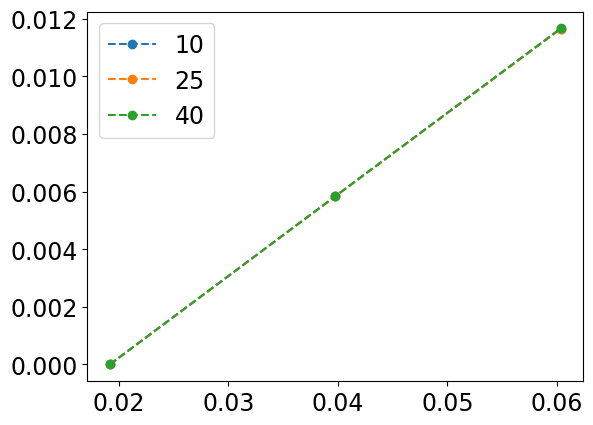

In [ ]:
for i,T_deg in enumerate([10,25,40]):
    plt.plot(
        midc_merge_all[i]['Throughput capacity [kA.h]'], 
        midc_merge_all[i]["CDend LLI lithium plating [%]"],
        '--o', label=str(T_deg))
plt.legend()